<a href="https://colab.research.google.com/github/Fernando-sys28/Genetic-Algorithm-of-Traveling-Salesman-problem/blob/main/Traveling_salesman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Graph with 12 nodes and 17 edges


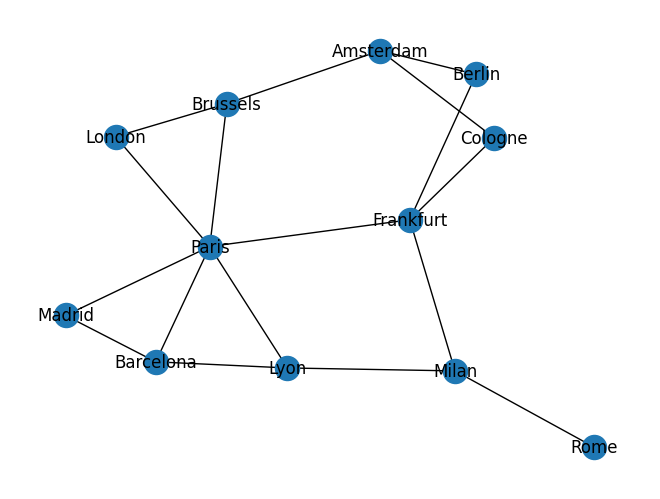

In [170]:
import networkx as nx
import matplotlib.pyplot as plt
# Crear un objeto grafo
graph = nx.Graph()

graph.add_nodes_from(["London", "Paris", "Madrid", "Barcelona", "Lyon", "Milan", "Rome", "Frankfurt", "Cologne", "Berlin", "Brussels", "Amsterdam"])


# London
graph.add_edge("London", "Paris", time=136, cost=98)
graph.add_edge("London", "Brussels", time=136, cost=98)

# Paris
graph.add_edge("Paris", "Madrid", time=225, cost=380)
graph.add_edge("Paris", "Barcelona", time=390, cost=400)
graph.add_edge("Paris", "Lyon", time=112, cost=185)
graph.add_edge("Paris", "Frankfurt", time=480, cost=345)
graph.add_edge("Paris", "Brussels", time=82, cost=80)

# Madrid
graph.add_edge("Madrid", "Barcelona", time=150, cost=98)

# Barcelona
graph.add_edge("Barcelona", "Lyon", time=200, cost=320)

# Lyon
graph.add_edge("Lyon", "Milan", time=176, cost=180)

# Milan
graph.add_edge("Milan", "Rome", time=168, cost=125)
graph.add_edge("Milan", "Frankfurt", time=454, cost=240)

# Frankfurt
graph.add_edge("Frankfurt", "Cologne", time=120, cost=40)
graph.add_edge("Frankfurt", "Berlin", time=232, cost=125)

# Brussels
graph.add_edge("Brussels", "Amsterdam", time=105, cost=48)

# Amsterdam
graph.add_edge("Amsterdam", "Berlin", time=364, cost=235)
graph.add_edge("Amsterdam", "Cologne", time=120, cost=40)


print(graph)
nx.draw(graph, with_labels=True)
plt.show()


In [93]:
import random
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt

class City:
    def __init__(self, name, neighbors):
        self.name = name
        self.neighbors = neighbors

    def distance(self, city):
        return self.neighbors[city.name]['cost']

    def travel_time(self, city):
        return self.neighbors[city.name]['time']

    def __repr__(self):
        return "(" + str(self.name) + ")"

class Fitness:
    def __init__(self, route):
        self.route = route
        self.cost = 0
        self.time = 0
        self.fitness = 0.0

    def routeDistance(self):
      if self.cost == 0:
          path_cost = 0
          path_time = 0
          for i in range(0, len(self.route)):
              fromCity = self.route[i]
              if i + 1 < len(self.route):
                  toCity = self.route[i + 1]
              else:
                  toCity = self.route[0]
              if toCity.name in fromCity.neighbors:
                  path_cost += fromCity.distance(toCity)
                  path_time += fromCity.travel_time(toCity)
          self.cost = path_cost
          self.time = path_time
      return self.cost, self.time

    def routeFitness(self):
        if self.fitness == 0:
            cost, time = self.routeDistance()
            if time > 4320:
                self.fitness = 0
            else:
                self.fitness = 1 / float(cost)
        return self.fitness

In [190]:
#Route generator
#This method randomizes the order of the cities, this mean that this method creates a random individual.
def createRoute(cityList, G):
    route = []
    remaining_cities = cityList.copy()

    current_city = random.choice(remaining_cities)
    remaining_cities.remove(current_city)
    route.append(current_city)

    while remaining_cities:
      available_cities = [city for city in remaining_cities if city.name in current_city.neighbors]

      if not available_cities:
          # If no available cities, return None
          return None

      next_city = random.choice(available_cities)
      route.append(next_city)
      remaining_cities.remove(next_city)
      current_city = next_city

    return route
#Create first "population" (list of routes)
#This method created a random population of the specified size.

def initialPopulation(popSize, cityList):
    population = []

    while len(population) < popSize:
        route = createRoute(cityList,G)
        if route is not None:
            population.append(route)
    print(population)
    return population

#Create the genetic algorithm
#Rank individuals
#This function takes a population and orders it in descending order using the fitness of each individual
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()

    sorted_results=sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    return sorted_results

#Create a selection function that will be used to make the list of parent routes

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#Create mating pool

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

#Create function to run crossover over full mating pool

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])

        # Verificar si todos los nodos en la ruta son vecinos
        valid_child = all(city1.name in city2.neighbors for city1, city2 in zip(child[:-1], child[1:]))

        if valid_child:
            children.append(child)
        else:
            # Descartar el hijo generado y volver a intentar con nuevos padres
            continue

    return children


#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]

            # Verificar si los nodos adyacentes son vecinos antes de realizar la mutación
            if (swapped == 0 or city2.name in individual[swapped - 1].neighbors) and \
               (swapped == len(individual) - 1 or city2.name in individual[swapped + 1].neighbors) and \
               (swapWith == 0 or city1.name in individual[swapWith - 1].neighbors) and \
               (swapWith == len(individual) - 1 or city1.name in individual[swapWith + 1].neighbors):

                individual[swapped] = city2
                individual[swapWith] = city1

    return individual

#Create function to run mutation over entire population

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop



#Put all steps together to create the next generation

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


In [191]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        best_fitness = rankRoutes(pop)[0][1]
        progress.append(best_fitness)
        best_route_index = rankRoutes(pop)[0][0]
        best_route = pop[best_route_index]
        best_route_fitness = Fitness(best_route)
        _, best_route_time = best_route_fitness.routeDistance()
        print(f"Generation {i+1}: Cost = {1/best_fitness:.2f}, Time = {best_route_time:.2f}, Fitness={best_fitness},Best Route:{[city.name for city in best_route]}")

    best_route_index = rankRoutes(pop)[0][0]
    best_route = pop[best_route_index]
    return best_route

In [193]:
cityList = [City(n, {nbr: graph.edges[n, nbr] for nbr in graph.neighbors(n)}) for n in graph.nodes()]

best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=40, mutationRate=0.3, generations=50)

# Obtener el tiempo del mejor recorrido
best_route_fitness = Fitness(best_route)
_, best_route_time = best_route_fitness.routeDistance()

print("Best Route:")
print([city.name for city in best_route])
print("Best Route Time:", best_route_time)

[[(Rome), (Milan), (Lyon), (Barcelona), (Madrid), (Paris), (London), (Brussels), (Amsterdam), (Cologne), (Frankfurt), (Berlin)], [(Berlin), (Frankfurt), (Cologne), (Amsterdam), (Brussels), (London), (Paris), (Madrid), (Barcelona), (Lyon), (Milan), (Rome)], [(Rome), (Milan), (Lyon), (Barcelona), (Madrid), (Paris), (London), (Brussels), (Amsterdam), (Berlin), (Frankfurt), (Cologne)], [(Cologne), (Frankfurt), (Berlin), (Amsterdam), (Brussels), (London), (Paris), (Madrid), (Barcelona), (Lyon), (Milan), (Rome)], [(Cologne), (Frankfurt), (Berlin), (Amsterdam), (Brussels), (London), (Paris), (Madrid), (Barcelona), (Lyon), (Milan), (Rome)], [(Rome), (Milan), (Lyon), (Barcelona), (Madrid), (Paris), (London), (Brussels), (Amsterdam), (Cologne), (Frankfurt), (Berlin)], [(Rome), (Milan), (Lyon), (Barcelona), (Madrid), (Paris), (London), (Brussels), (Amsterdam), (Cologne), (Frankfurt), (Berlin)], [(Rome), (Milan), (Lyon), (Barcelona), (Madrid), (Paris), (London), (Brussels), (Amsterdam), (Berlin), 